# Use Case: Creating a Coding Agent


[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mongodb-developer/GenAI-Showcase/blob/main/partners/langchain/ai_hallucination_detection_and_reduction.ipynb)

[![AI Learning Hub](https://img.shields.io/badge/AI%20Learning%20Hub-Click%20Here-blue)](https://www.mongodb.com/resources/use-cases/artificial-intelligence?utm_campaign=ai_learning_hub&utm_source=github&utm_medium=referral)

**Primary Objective:**
Create an intelligent coding agent that can analyze GitHub repositories and assist with code-related tasks.

This system is built to improve developer productivity focusing on the following example scenarios:
1. Code discovery and navigation
2. Repository ingestion
3. Automated unit test creation


**Components:**
- Gitingest: Converts GitHub repositories into structured markdown format for processing and analysis
- VoyageAI - Generates high-quality code-specific embeddings using the voyage-code-3 model for semantic search
- OpenAI - Powers text generation via GPT-4.1
- PyMongo - Manages MongoDB connections and operations for storing codebase metadata, files, and embeddings
- Galileo - Monitors and evaluates AI responses for hallucination detection and quality assessment metrics
- LangGraph - Orchestrates complex agent workflows and manages state transitions for multi-step coding tasks


**This notebook contains three main parts:**

- Part 1: Data Ingestion, Preparation and Storage
- Part 2: Information Retrieval and RAG
- Part 3: Coding Agent

**What you will learn**
- ✅ Building production-ready RAG systems
- ✅ Implementing advanced vector search strategies
- ✅ Creating AI-powered coding assistants
- ✅ Establishing comprehensive AI monitoring
- ✅ Designing agentic workflows with tool integration
- ✅ Evaluating and improving AI system quality

**Key topics explored:** Multi-modal RAG architecture, MongoDB Atlas vector search, embeddings, hybrid search with RankFusion, AI hallucination detection using Galileo, agentic workflows with LangGraph, GitHub repository processing with GitIngest, quality evaluation frameworks, tool development and integration, and production-ready AI observability patterns.

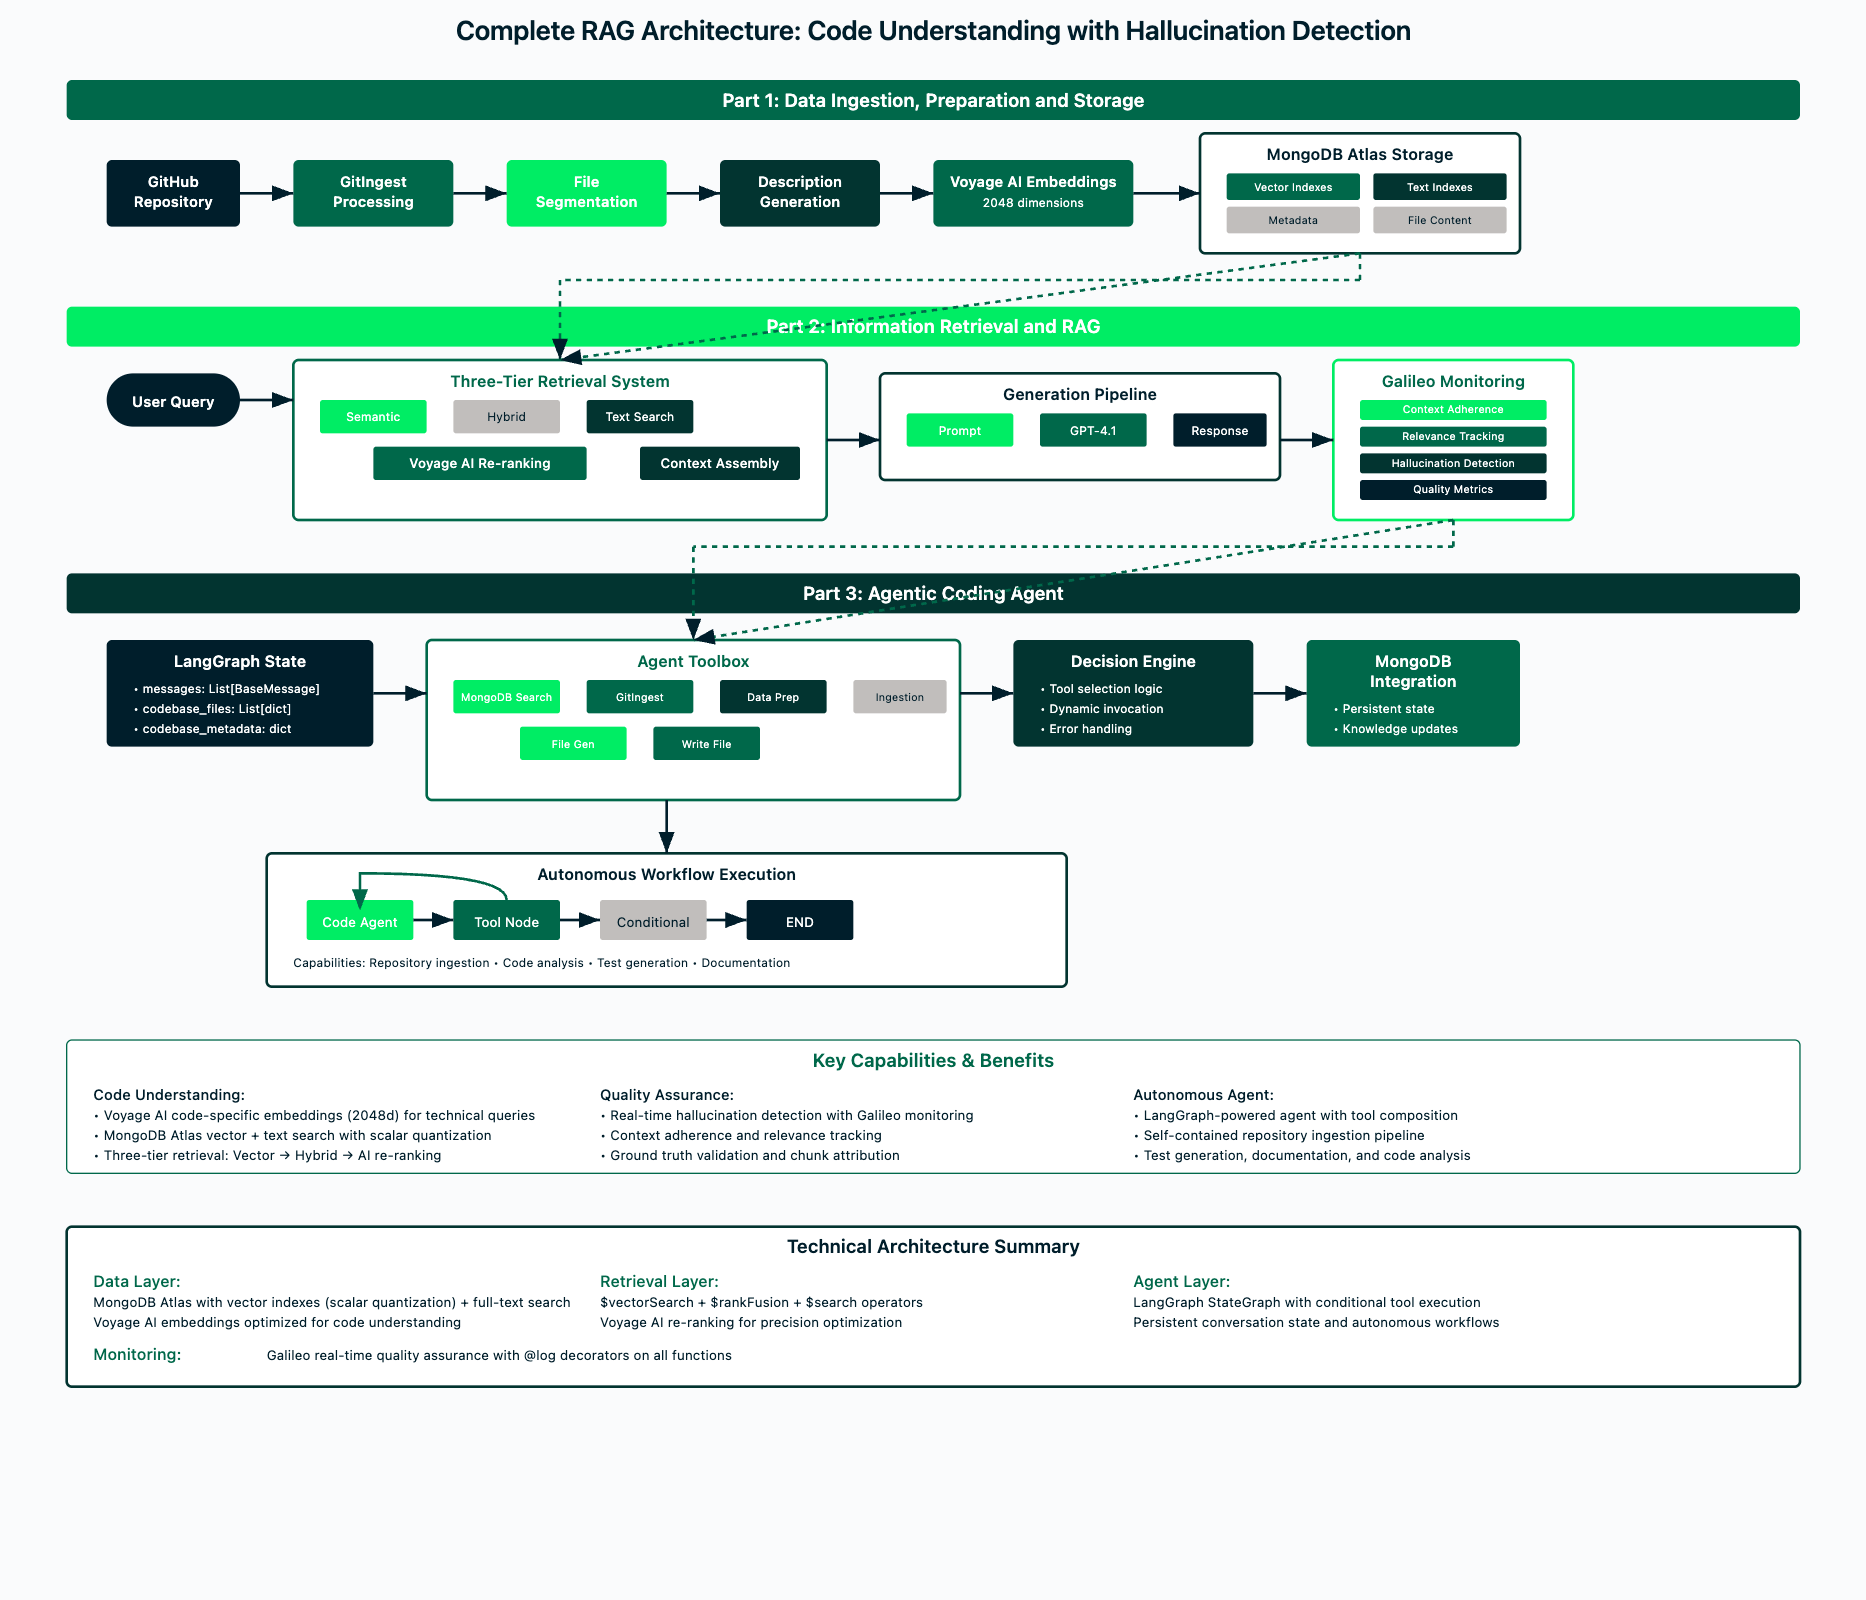

# Setup: Intalling Packages and Environment Variables

In [54]:
! pip install -qU gitingest voyageai openai pymongo "galileo[openai]" langgraph-checkpoint-mongodb langgraph langchain pandas langchain-openai

In [3]:
import getpass
import os


# Function to securely get and set environment variables
def set_env_securely(var_name, prompt):
    value = getpass.getpass(prompt)
    os.environ[var_name] = value

This code configures Galileo's AI monitoring platform for tracking system performance and detecting hallucinations.
Get your Galileo API Key here:

In [4]:
set_env_securely("GALILEO_API_KEY", "Enter your Galileo API key: ")

Securely captures and stores the Galileo API key using masked input (like password entry)
- GALILEO_PROJECT: Organizes AI experiments under a project container
- GALILEO_LOG_STREAM: Categorizes logs within the project for different experiment types

Once configured, Galileo automatically tracks retrieval quality, hallucination rates, and AI response accuracy when functions are decorated with @log(). This provides enterprise-grade monitoring without building custom evaluation infrastructure, essential for reliable production AI applications.

In [5]:
# Optional, set a default Project
os.environ["GALILEO_PROJECT"] = "TEST"

# Optional, set a default Log Stream
os.environ["GALILEO_LOG_STREAM"] = "TEST_LOGS"

# Part 1: Data Ingestion, Preparation and Storage

Part 1: Data Ingestion Process Overview

**The data ingestion pipeline transforms raw GitHub repositories into a searchable, AI-ready knowledge base through four key stages:**

**1. Repository Extraction**
- **GitIngest** processes the GitHub URL and extracts the entire codebase structure
- Analyzes repository tree, file relationships, and content hierarchy
- Converts source code into structured, processable format

**2. Intelligent Segmentation**
- **File-level chunking** breaks down the codebase into manageable pieces
- **Content parsing** identifies code structure, functions, classes, and documentation
- **Smart boundaries** ensure logical code blocks remain intact

**3. AI-Powered Description Generation**
- **Context-aware summaries** created for each file using AI
- **Code understanding** generates human-readable descriptions of what each file does
- **Semantic enrichment** adds searchable metadata beyond just raw code

**4. Code-Specific Embeddings**
- **Voyage AI embeddings (2048d)**: Code-optimized vector representations for technical searches
- **Specialized models** trained specifically for understanding code semantics and structure
- **Enhanced retrieval** for programming-related queries and code comprehension

**5. MongoDB Atlas Storage**
- **Vector indexes** with scalar quantization for efficient similarity search
- **Text indexes** for keyword-based searches
- **Dual collections**: Metadata and file content stored separately for optimal performance

**Result**: A GitHub repository becomes a fully searchable, semantically-understood knowledge base ready for sophisticated RAG queries, with both vector similarity and traditional text search capabilities optimized for code understanding.

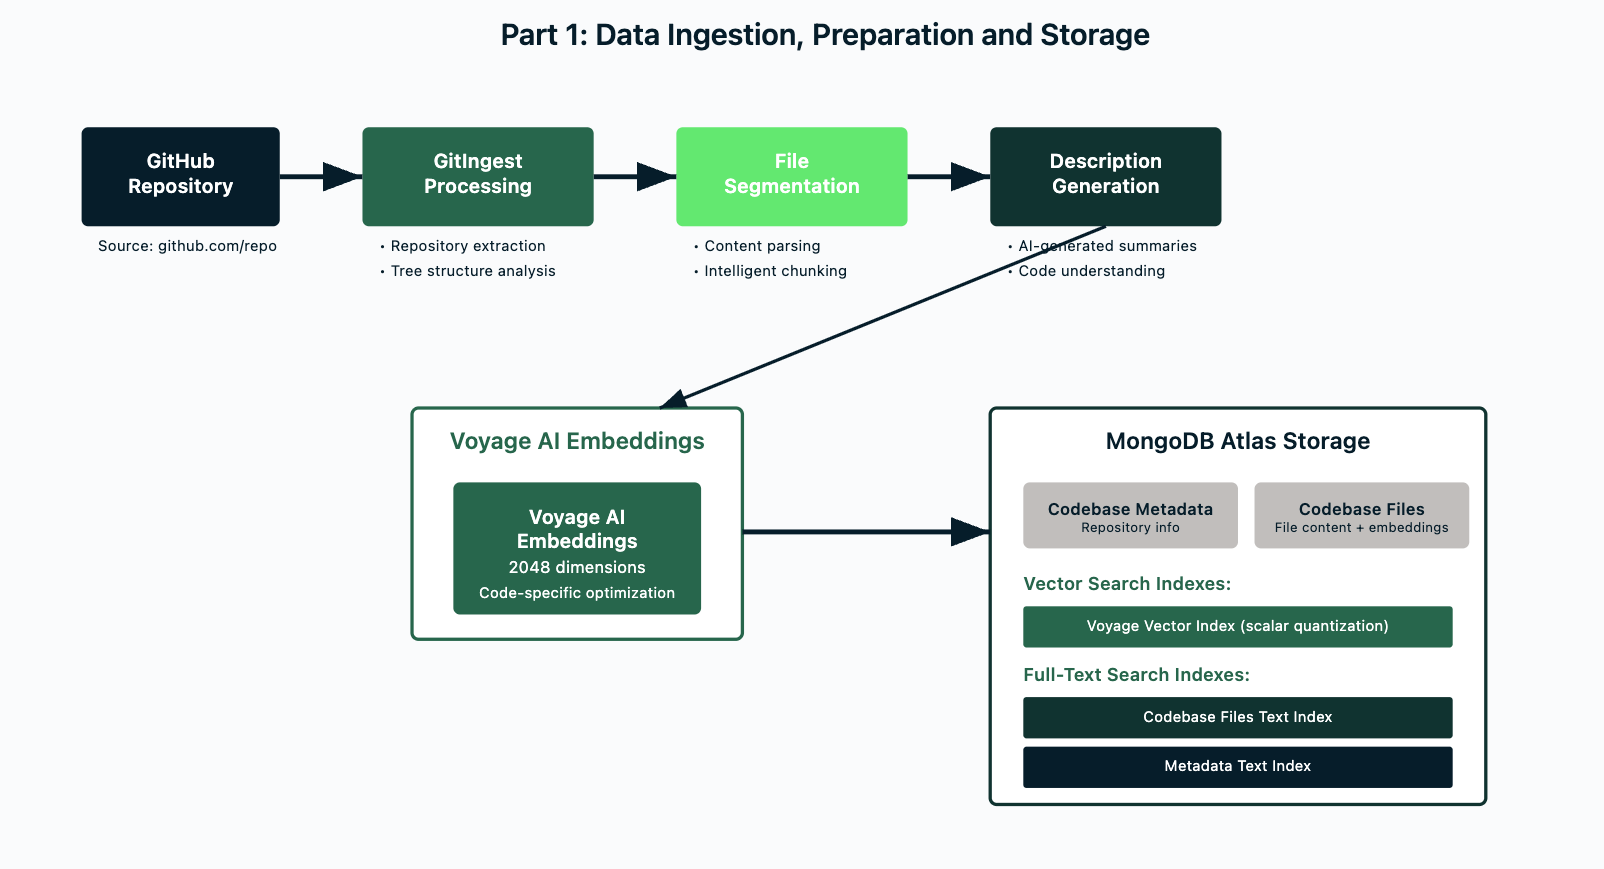

## 1.1 Repository Extraction

The ```codebase_metadata``` dictionary serves as a repository-level data container that captures high-level information about the entire GitHub repository being processed:

Example of what an object can look like below:

```
codebase_metadata = {
    "url": "https://github.com/RichmondAlake/memorizz",
    "repository": "richmondalake/memorizz",
    "analyzed_count": "57",              # Number of files processed
    "estimated_tokens": "101.0k",        # Total token count
    "tree": "Directory structure...",     # Full directory tree
    "description": "AI-generated repo summary...",
    "voyage_embeddings": [0.3, 0.4, ...]
}
````


In [ ]:
codebase_metadata = {}

Provide the url of the codebase you want to process.
You can change the URL below for any url of your choice

In [ ]:
codebase_metadata["url"] = "https://github.com/RichmondAlake/memorizz"

GitIngest is a specialized tool that converts GitHub repositories into structured markdown format for AI processing. The ingest_async function is its asynchronous interface.

Without GitIngest, developers would need to manually clone repos, parse file structures, and format content - GitIngest automates this entire pipeline into a single async function call.

In [ ]:
from gitingest import ingest_async

summary, tree, content = await ingest_async(codebase_metadata.get("url"))

In [ ]:
print(summary)

Repository: richmondalake/memorizz
Files analyzed: 57

Estimated tokens: 101.0k


In [ ]:
attrs = {}
for line in summary.splitlines():
    line = line.strip()
    if not line or ":" not in line:
        continue
    key, val = line.split(":", 1)
    attrs[key.lower().replace(" ", "_")] = val.strip()

In [ ]:
codebase_metadata["repository"] = attrs.get("repository")
codebase_metadata["analyzed_count"] = attrs.get("files_analyzed")
codebase_metadata["estimated_tokens"] = attrs.get("estimated_tokens")

In [ ]:
import pprint

pprint.pprint(codebase_metadata)

In [ ]:
codebase_metadata["tree"] = tree

In [ ]:
print(codebase_metadata["tree"])

## 1.2 Intelligent Segmentation

In [7]:
set_env_securely("OPENAI_API_KEY", "Enter your OPENAI_API_KEY: ")

This code below imports Galileo's instrumented version of the OpenAI client and context manager:

```python
from galileo.openai import openai, galileo_context
```

This line **imports Galileo's instrumented version of the OpenAI client** and context manager:

**What it imports:**

1. **`openai`**: A **wrapped OpenAI client** that automatically logs all API calls to Galileo
   - Replaces the standard `import openai`
   - Every API call (completions, embeddings, etc.) is automatically monitored
   - Captures tokens used, response times, model performance metrics

2. **`galileo_context`**: A **context manager** for controlling when logging happens
   - Used to flush logs to Galileo's servers: `galileo_context.flush()`
   - Manages logging sessions and ensures data is properly uploaded

**Why use this instead of regular OpenAI?**
- **Automatic Monitoring**: No need to manually instrument every API call
- **Hallucination Detection**: Galileo analyzes responses for accuracy and reliability
- **Cost Tracking**: Monitors token usage and API costs across all calls
- **Performance Analytics**: Tracks response times and error rates

This provides **zero-code observability** - just replace the import and get comprehensive AI monitoring.

In [8]:
from typing import Dict

from galileo.openai import galileo_context, openai

openai_client = openai.OpenAI()

The `generate_repo_description` uses AI to automatically write a README-style summary of what a GitHub repository does.

1. Takes in: Repository information (name, URL, file count, directory structure) + a snippet of the actual code
2. Asks GPT-4: "Look at this repo data and write a paragraph explaining what this codebase is for"
3. Returns: An AI-generated description that explains the repository's purpose, structure, and goals


**Why it's useful:**
- Automatic Documentation: No need to manually write repo descriptions
- Consistent Format: Always produces well-structured summaries
- Context Aware: Understands what the code actually does by analyzing the content
- Searchable Metadata: Creates text that can be embedded and searched later

In [ ]:
def generate_repo_description(
    metadata: Dict[str, str],
    content: str,
    model: str = "gpt-4.1",
    snippet_length: int = 1000,
) -> str:
    """
    Generate a Markdown README-style description of a GitHub repo using the
    OpenAI Response API. The description will:
      - Name the repo and link to it
      - Mention how many files were analyzed and the approximate token count
      - Summarize the high-level directory structure (major folders)
      - Infer the repository's purpose and main goals

    Args:
        metadata: dict with keys:
            - repository: "owner/name"
            - url: repo URL
            - analyzed_count: number of files analyzed (string or int)
            - estimated_tokens: e.g. "101.0k"
            - tree: full directory structure string
        model: which OpenAI model to call (default "gpt-4.1")

    Returns:
        A Markdown-formatted description string.
    """
    # Extract just the top-level entries for brevity
    tree_lines = metadata.get("tree", "").splitlines()
    top_level = "\n".join(tree_lines[:4])  # e.g. the first three indented lines

    prompt = f"""
You are a documentation assistant. Using the metadata and a snippet of the repository's content,
write a concise, engaging README-style paragraph in Markdown that:
- Names the repository and links to it
- Mentions how many files were analyzed and the approximate token count
- Summarizes the high-level directory structure (major folders)
- Infers the repository's purpose and primary goals
- Highlights any notable code patterns or core modules from the provided content snippet


Metadata:
Repository: {metadata.get('repository')}
URL: {metadata.get('url')}
Files analyzed: {metadata.get('analyzed_count')}
Estimated tokens: {metadata.get('estimated_tokens')}

Top-level directory structure:
{top_level}

Content snippet:
{content.strip()[:snippet_length]}

Please produce one well-crafted paragraph.
"""

    response = openai_client.responses.create(model=model, input=prompt)
    return response.output_text.strip()

In [ ]:
codebase_metadata["description"] = generate_repo_description(codebase_metadata, content)

In [ ]:
pprint.pprint(codebase_metadata["description"])

('[**richmondalake/memorizz**](https://github.com/RichmondAlake/memorizz) is '
 'an experimental Python library focused on advanced memory management for AI '
 'agents, providing core infrastructure to store, retrieve, and utilize '
 'contextual knowledge in agent-based systems. With a codebase spanning 57 '
 'files and approximately 101,000 tokens, the repository is structured with '
 'essential top-level files like `README.md` and `LICENCE.txt`, making entry '
 'points clear for new contributors or users. The primary aim of Memorizz is '
 'to facilitate research and education on agent memory architectures, '
 'deliberately warning against use in production or with sensitive data. '
 'Notable patterns include strong modularization for memory operations and '
 'clear emphasis on both extensibility and educational clarity. The project’s '
 'core modules likely revolve around agent memory APIs and storage mechanisms, '
 'supporting experimentation in cognitive AI system design.')


In [ ]:
print(content[0:1000])

FILE: README.md
<div align="center">

# Memorizz 🧠

📊 **[Agent Memory Presentation](https://docs.google.com/presentation/d/1iSu667m5-pOXMrJq_LjkfnfD4V0rW1kbhGaQ2u3TKXQ/edit?usp=sharing)** | 🎥 **[AIEWF Richmond's Talk](https://youtu.be/W2HVdB4Jbjs?si=faaI3cMLc71Efpeu)**

[![PyPI version](https://badge.fury.io/py/memorizz.svg)](https://badge.fury.io/py/memorizz)
[![PyPI downloads](https://img.shields.io/pypi/dm/memorizz.svg)](https://pypistats.org/packages/memorizz)

</div>

> **⚠️ IMPORTANT WARNING ⚠️**
> 
> **MemoRizz is an EXPERIMENTAL library intended for EDUCATIONAL PURPOSES ONLY.**
> 
> **Do NOT use in production environments or with sensitive data.**
> 
> This library is under active development, has not undergone security audits, and may contain bugs or breaking changes in future releases.

## Overview

MemoRizz is an advanced memory management framework designed for AI agents, enabl


## 1.3 AI-Powered Description Generation

The function `split_content_to_files` takes a giant string containing multiple files and splits it into individual files.

Process:
- Finds file separators: Looks for the ====\nFILE: markers that divide files
- Extracts each file: For each section, grabs the filename and content
- Cleans up paths: Converts src/main.py to just main.py

**Why it's needed:**
-GitIngest gives you **one big markdown** blob with all files concatenated together. This function **unpacks that blob** into individual, manageable file objects that can be processed separately (for embeddings, descriptions, etc.).

Bottom line: It's a parser that converts "one giant file containing everything" into "a list of individual files" - like unzipping a compressed archive.

In [ ]:
import os
import re


def split_content_to_files(content_blob: str):
    # Split on the "====\nFILE: " marker
    parts = re.split(r"^={2,}\nFILE: ", content_blob, flags=re.MULTILINE)
    files = []
    for part in parts[1:]:
        # part starts with: "<path>\n====\n<rest of file>"
        lines = part.splitlines()
        full_path = lines[0].strip()  # e.g. "README.md" or "src/foo.py"
        file_name = os.path.basename(full_path)  # e.g. "README.md" or "foo.py"
        # Skip the next separator line, then the rest is content
        content = "\n".join(lines[2:]).rstrip()
        files.append({"file_name": file_name, "content": content})
    return files

In [ ]:
files = split_content_to_files(content)

In [ ]:
pprint.pprint(files[0])

The function `generate_file_description` uses AI to automatically write a one-sentence summary of what each individual file does.

**Input:**
* File name: "memagent.py"
* File content: The entire Python code

**Process:**
1. Takes a snippet: Grabs first 100 characters of the file content
2. Asks GPT-4: "Look at this filename and code snippet, write one sentence explaining what this file does"
3. Gets AI response: A concise description

**Output:**
> "The memagent.py file defines a memory-driven agent by integrating persona management, OpenAI language model support, and a customizable toolbox for executing tasks."

In [ ]:
def generate_file_description(
    file_name: str, content: str, model: str = "gpt-4.1", snippet_length: int = 100
) -> str:
    """
    Generate a brief description of a single file using the OpenAI Response API.

    Args:
        file_name: Name of the file (e.g. "memagent.py")
        content:   Full text of the file
        model:     OpenAI model to use (default "gpt-4.1")
        snippet_length: Number of characters from the start of `content` to include in prompt

    Returns:
        A short Markdown sentence describing the file purpose.
    """
    # Grab a small snippet for context
    snippet = content.strip()[:snippet_length].replace("\n", " ")

    prompt = f"""
    You are a code documentation assistant. Write a one-sentence Markdown
    description of the file "{file_name}", based on this snippet:

    ```txt
    {snippet}

    Description:
    """.strip()

    # Call the OpenAI Response API
    response = openai_client.responses.create(model=model, input=prompt)

    return response.output_text.strip()

Quick test of the description function

In [ ]:
files[0]["description"] = generate_file_description(
    files[0]["file_name"], files[0]["content"]
)

In [ ]:
files[0]["description"]

'A Markdown file introducing Memorizz, featuring a centered header, emoji, and a link to the Agent Memory Presentation.'

In [ ]:
# Generate the descriptions for the codebase_metadata and the codebase_files
for file in files:
    file["description"] = generate_file_description(file["file_name"], file["content"])

## 1.4 Code-Specific Embeddings

Get your Voyage AI API from:

In [9]:
set_env_securely("VOYAGE_API_KEY", "Enter your Voyage API Key: ")

The `get_voyage_embedding` function converts text into a list of numbers that represent the meaning of the text - these numbers are called "embeddings".

**Input:**
- Any text (like "This function handles user authentication")

**Process:**
- Sends text to Voyage AI: Uses their voyage-code-3 model (specially trained for code)
- Gets back numbers: Receives 2048 numbers that capture the text's meaning
- Returns the list: [0.1, -0.3, 0.7, 0.2, ...] (2048 numbers total)

>Output: A list of 2048 floating-point numbers

**Why embeddings matter:**
- Semantic Understanding: Similar meanings = similar numbers
- Searchable: Can find related code by comparing number patterns
- AI-Friendly: Machine learning models work with numbers, not text

**Why Voyage AI specifically:**
- Code-Specialized: voyage-code-3 understands programming concepts better than general models
- High Quality: Designed specifically for code similarity and search
- Optimized Dimensions: 2048 numbers provide good balance of detail vs. efficiency

In [10]:
from typing import List

import voyageai

vo = voyageai.Client()


def get_voyage_embedding(data: str) -> List:
    """
    Get Voyage AI embeddings for text.

    Args:
        data (str): A text to embed.
        input_type (str): Input type, either "document" or "query".

    Returns:
        List: Embeddings as a list.
    """
    embedding = vo.embed(
        texts=data, model="voyage-code-3", truncation=False, output_dimension=2048
    ).embeddings[0]
    return embedding

/Users/richmondalake/miniconda3/envs/galileo_webinars/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:
def get_openai_embedding(data: str) -> List:
    """
    Get OpenAI embeddings for text.

    Args:
        data (str): A text to embed.

    Returns:
        List: Embeddings as a list.
    """
    response = openai_client.embeddings.create(
        input=data, model="text-embedding-3-large", dimensions=3072
    )
    return response.data[0].embedding

In [ ]:
# Create the embeddings for the codebase_metadata
# convert the codebase_metadata to dataframe

import pandas as pd

codebase_metadata_df = pd.DataFrame([codebase_metadata])
codebase_metadata_df

,url,repository,analyzed_count,estimated_tokens,tree,description
0,https://github.com/RichmondAlake/memorizz,richmondalake/memorizz,57,101.0k,Directory structure:\n└── richmondalake-memori...,[**richmondalake/memorizz**](https://github.co...


In [ ]:
# Create the embeddings for the codebase_metadata
# convert the codebase_metadata to dataframe
from tqdm.auto import tqdm

# Enable the pandas “progress_apply” method
tqdm.pandas()

codebase_metadata_df["openai_embeddings"] = codebase_metadata_df[
    "description"
].progress_apply(get_openai_embedding)
codebase_metadata_df["voyage_embeddings"] = codebase_metadata_df[
    "description"
].progress_apply(get_voyage_embedding)

100%|██████████| 1/1 [00:00<00:00,  2.19it/s]


In [ ]:
codebase_metadata_df

,url,repository,analyzed_count,estimated_tokens,tree,description,openai_embeddings,voyage_embeddings
0,https://github.com/RichmondAlake/memorizz,richmondalake/memorizz,57,101.0k,Directory structure:\n└── richmondalake-memori...,[**richmondalake/memorizz**](https://github.co...,"[-0.013910239562392235, 0.0077960304915905, -0...","[-0.01897663064301014, 0.019311921671032906, -..."


In [ ]:
# Generate embeddings for the codebase_files
code_base_files_df = pd.DataFrame(files)
code_base_files_df.head()

,file_name,content,description
0,README.md,"<div align=""center"">\n\n# Memorizz 🧠\n\n📊 **[A...",A detailed overview and guide for the Memorizz...
1,LICENCE.txt,MIT License\n\nCopyright (c) 2024 Richmond Ala...,"This file contains the MIT License, granting p..."
2,pyproject.toml,"[build-system]\nrequires = [""hatchling""]\nbuil...",The pyproject.toml file specifies build system...
3,README.md,# Memorizz Evaluation Framework\n\nThis direct...,Description: This README.md provides an overvi...
4,README.md,# LongMemEval Evaluation for Memorizz\n\nThis ...,The `README.md` file provides an overview and ...


In [ ]:
code_base_files_df["openai_embeddings"] = code_base_files_df[
    "description"
].progress_apply(get_openai_embedding)

code_base_files_df["voyage_embeddings"] = code_base_files_df[
    "description"
].progress_apply(get_voyage_embedding)

100%|██████████| 57/57 [00:15<00:00,  3.67it/s]


In [ ]:
code_base_files_df.head()

,file_name,content,description,openai_embeddings,voyage_embeddings
0,README.md,"<div align=""center"">\n\n# Memorizz 🧠\n\n📊 **[A...",A detailed overview and guide for the Memorizz...,"[-0.022689061239361763, -0.024230889976024628,...","[-0.014513802714645863, 0.020234525203704834, ..."
1,LICENCE.txt,MIT License\n\nCopyright (c) 2024 Richmond Ala...,"This file contains the MIT License, granting p...","[0.0009140886832028627, 0.0029062831308692694,...","[-0.024665705859661102, 0.049052704125642776, ..."
2,pyproject.toml,"[build-system]\nrequires = [""hatchling""]\nbuil...",The pyproject.toml file specifies build system...,"[-0.06007716432213783, 0.013143442571163177, -...","[-0.03296789899468422, 0.020944518968462944, -..."
3,README.md,# Memorizz Evaluation Framework\n\nThis direct...,Description: This README.md provides an overvi...,"[-0.020649829879403114, 0.005917594768106937, ...","[-0.027502847835421562, -0.0006511090905405581..."
4,README.md,# LongMemEval Evaluation for Memorizz\n\nThis ...,The `README.md` file provides an overview and ...,"[-0.02544913813471794, -0.0007917052134871483,...","[-0.036813315004110336, 0.011114790104329586, ..."


## 1.5 MongoDB Atlas Storage

Ensure to get your MongoDB URI:

In [12]:
set_env_securely("MONGODB_URI", "Enter your MongoDB URI: ")

In [13]:
import pymongo


def get_mongo_client(mongo_uri):
    """Establish and validate connection to the MongoDB."""

    client = pymongo.MongoClient(
        mongo_uri,
        appname="devrel.showcase.partners.galileo.ai_hallucination_detection_and_reduction",
    )

    # Validate the connection
    ping_result = client.admin.command("ping")
    if ping_result.get("ok") == 1.0:
        # Connection successful
        print("Connection to MongoDB successful")
        return client
    else:
        print("Connection to MongoDB failed")
    return None

In [14]:
DB_NAME = "code_repository_data"
db_client = get_mongo_client(os.environ.get("MONGODB_URI"))
db = db_client[DB_NAME]

Connection to MongoDB successful


In [15]:
# Collection names
CODEBASE_METADATA = "codebase_metadata"
CODEBASE_FILES = "codebase_files"

In [ ]:
# Create collections
def create_collections():
    existing_collections = db.list_collection_names()
    print(f"Existing collections: {existing_collections}")

    # If the collection does not exist, create it
    if CODEBASE_METADATA not in existing_collections:
        db.create_collection(CODEBASE_METADATA)
        print(f"Created collection: {CODEBASE_METADATA}")
    else:
        print(f"Collection {CODEBASE_METADATA} already exists")

    if CODEBASE_FILES not in existing_collections:
        db.create_collection(CODEBASE_FILES)
        print(f"Created collection: {CODEBASE_FILES}")
    else:
        print(f"Collection {CODEBASE_FILES} already exists")

In [ ]:
create_collections()

Existing collections: []
Created collection: codebase_metadata
Created collection: codebase_files


In [ ]:
# Create Indexes
import time

from pymongo.operations import SearchIndexModel


# Create vector search index if it doesn't exist
def create_vector_search_index(
    collection,
    vector_index_name,
    dimensions=1024,
    quantization="scalar",
    embedding_path="embedding",
):
    # Check if index already exists
    try:
        existing_indexes = collection.list_search_indexes()
        for index in existing_indexes:
            if index["name"] == vector_index_name:
                print(f"Vector search index '{vector_index_name}' already exists.")
                return
    except Exception as e:
        print(f"Could not list search indexes: {e}")
        return

    index_definition = {
        "fields": [
            {
                "type": "vector",
                "path": embedding_path,
                "numDimensions": dimensions,
                "similarity": "cosine",
            }
        ]
    }

    if quantization == "scalar":
        index_definition["fields"][0]["quantization"] = quantization

    if quantization == "binary":
        index_definition["fields"][0]["quantization"] = quantization

    # Adding prefiltering for codebase_files collection
    # This helps to reduce the number of documents that need to be processed by the vector search
    if collection.name == "codebase_files":
        index_definition["fields"].append(
            {
                "type": "filter",
                "path": "description",
            }
        )

    # Create vector search index
    search_index_model = SearchIndexModel(
        definition=index_definition,
        name=vector_index_name,
        type="vectorSearch",
    )

    try:
        result = collection.create_search_index(model=search_index_model)
        print(f"New search index named '{result}' is building.")
    except Exception as e:
        print(f"Error creating vector search index: {e}")
        return

    # Wait for initial sync to complete
    print(
        f"Polling to check if the index '{result}' is ready. This may take up to a minute."
    )
    predicate = lambda index: index.get("queryable") is True

    while True:
        try:
            indices = list(collection.list_search_indexes(result))
            if indices and predicate(indices[0]):
                break
            time.sleep(5)
        except Exception as e:
            print(f"Error checking index readiness: {e}")
            time.sleep(5)

    print(f"{result} is ready for querying.")

In [ ]:
create_vector_search_index(
    db[CODEBASE_METADATA],
    "vector_search_index_scalar_openai",
    quantization="scalar",
    embedding_path="openai_embeddings",
    dimensions=3072,
)

create_vector_search_index(
    db[CODEBASE_METADATA],
    "vector_search_index_scalar_voyage",
    quantization="scalar",
    embedding_path="voyage_embeddings",
    dimensions=2048,
)

create_vector_search_index(
    db[CODEBASE_FILES],
    "vector_search_index_scalar_voyage",
    quantization="scalar",
    embedding_path="voyage_embeddings",
    dimensions=2048,
)

create_vector_search_index(
    db[CODEBASE_FILES],
    "vector_search_index_scalar_openai",
    quantization="scalar",
    embedding_path="openai_embeddings",
    dimensions=3072,
)

New search index named 'vector_search_index_scalar_openai' is building.
Polling to check if the index 'vector_search_index_scalar_openai' is ready. This may take up to a minute.
vector_search_index_scalar_openai is ready for querying.
New search index named 'vector_search_index_scalar_voyage' is building.
Polling to check if the index 'vector_search_index_scalar_voyage' is ready. This may take up to a minute.
vector_search_index_scalar_voyage is ready for querying.
New search index named 'vector_search_index_scalar_voyage' is building.
Polling to check if the index 'vector_search_index_scalar_voyage' is ready. This may take up to a minute.
vector_search_index_scalar_voyage is ready for querying.
New search index named 'vector_search_index_scalar_openai' is building.
Polling to check if the index 'vector_search_index_scalar_openai' is ready. This may take up to a minute.
vector_search_index_scalar_openai is ready for querying.


In [ ]:
def create_text_search_index(collection, index_definition, index_name):
    """
    Create a search index for a MongoDB Atlas collection.

    Args:
    collection: MongoDB collection object
    index_definition: Dictionary defining the index mappings
    index_name: String name for the index

    Returns:
    str: Result of the index creation operation
    """

    try:
        search_index_model = SearchIndexModel(
            definition=index_definition, name=index_name
        )

        result = collection.create_search_index(model=search_index_model)
        print(f"Search index '{index_name}' created successfully")
        return result
    except Exception as e:
        print(f"Error creating search index: {e!s}")
        return None

In [ ]:
codebase_metadata_index_definition = {
    "mappings": {
        "dynamic": True,
        "fields": {
            "repository": {
                "type": "string",
            },
            "url": {
                "type": "string",
            },
            "description": {
                "type": "string",
            },
        },
    }
}

In [ ]:
codebase_files_index_definition = {
    "mappings": {
        "dynamic": True,
        "fields": {
            "file_path": {
                "type": "string",
            },
            "description": {
                "type": "string",
            },
            "content": {
                "type": "string",
            },
        },
    }
}

In [ ]:
create_text_search_index(
    db[CODEBASE_METADATA],
    codebase_metadata_index_definition,
    "codebase_metadata_index",
)

create_text_search_index(
    db[CODEBASE_FILES],
    codebase_files_index_definition,
    "codebase_files_index",
)

Search index 'codebase_metadata_index' created successfully
Search index 'codebase_files_index' created successfully


'codebase_files_index'

In [ ]:
# Ensure the collections are empty
db[CODEBASE_METADATA].delete_many({})
db[CODEBASE_FILES].delete_many({})

DeleteResult({'n': 0, 'electionId': ObjectId('7fffffff0000000000000003'), 'opTime': {'ts': Timestamp(1751631946, 1), 't': 3}, 'ok': 1.0, '$clusterTime': {'clusterTime': Timestamp(1751631946, 1), 'signature': {'hash': b"\xa9\x0f\xc5\x85\xa1['g\x90F\x14*\xc2Yx\xdd%;\xe6|", 'keyId': 7520068280199938053}}, 'operationTime': Timestamp(1751631946, 1)}, acknowledged=True)

In [ ]:
# Insert the codebase metadata documents into the collection
codebase_metadata_documents = codebase_metadata_df.to_dict(orient="records")
codebase_files_documents = code_base_files_df.to_dict(orient="records")

db[CODEBASE_METADATA].insert_many(codebase_metadata_documents)
db[CODEBASE_FILES].insert_many(codebase_files_documents)

InsertManyResult([ObjectId('6867c84f3947e1e6a1b6db8d'), ObjectId('6867c84f3947e1e6a1b6db8e'), ObjectId('6867c84f3947e1e6a1b6db8f'), ObjectId('6867c84f3947e1e6a1b6db90'), ObjectId('6867c84f3947e1e6a1b6db91'), ObjectId('6867c84f3947e1e6a1b6db92'), ObjectId('6867c84f3947e1e6a1b6db93'), ObjectId('6867c84f3947e1e6a1b6db94'), ObjectId('6867c84f3947e1e6a1b6db95'), ObjectId('6867c84f3947e1e6a1b6db96'), ObjectId('6867c84f3947e1e6a1b6db97'), ObjectId('6867c84f3947e1e6a1b6db98'), ObjectId('6867c84f3947e1e6a1b6db99'), ObjectId('6867c84f3947e1e6a1b6db9a'), ObjectId('6867c84f3947e1e6a1b6db9b'), ObjectId('6867c84f3947e1e6a1b6db9c'), ObjectId('6867c84f3947e1e6a1b6db9d'), ObjectId('6867c84f3947e1e6a1b6db9e'), ObjectId('6867c84f3947e1e6a1b6db9f'), ObjectId('6867c84f3947e1e6a1b6dba0'), ObjectId('6867c84f3947e1e6a1b6dba1'), ObjectId('6867c84f3947e1e6a1b6dba2'), ObjectId('6867c84f3947e1e6a1b6dba3'), ObjectId('6867c84f3947e1e6a1b6dba4'), ObjectId('6867c84f3947e1e6a1b6dba5'), ObjectId('6867c84f3947e1e6a1b6db

# Part 2: Information Retrieval and RAG

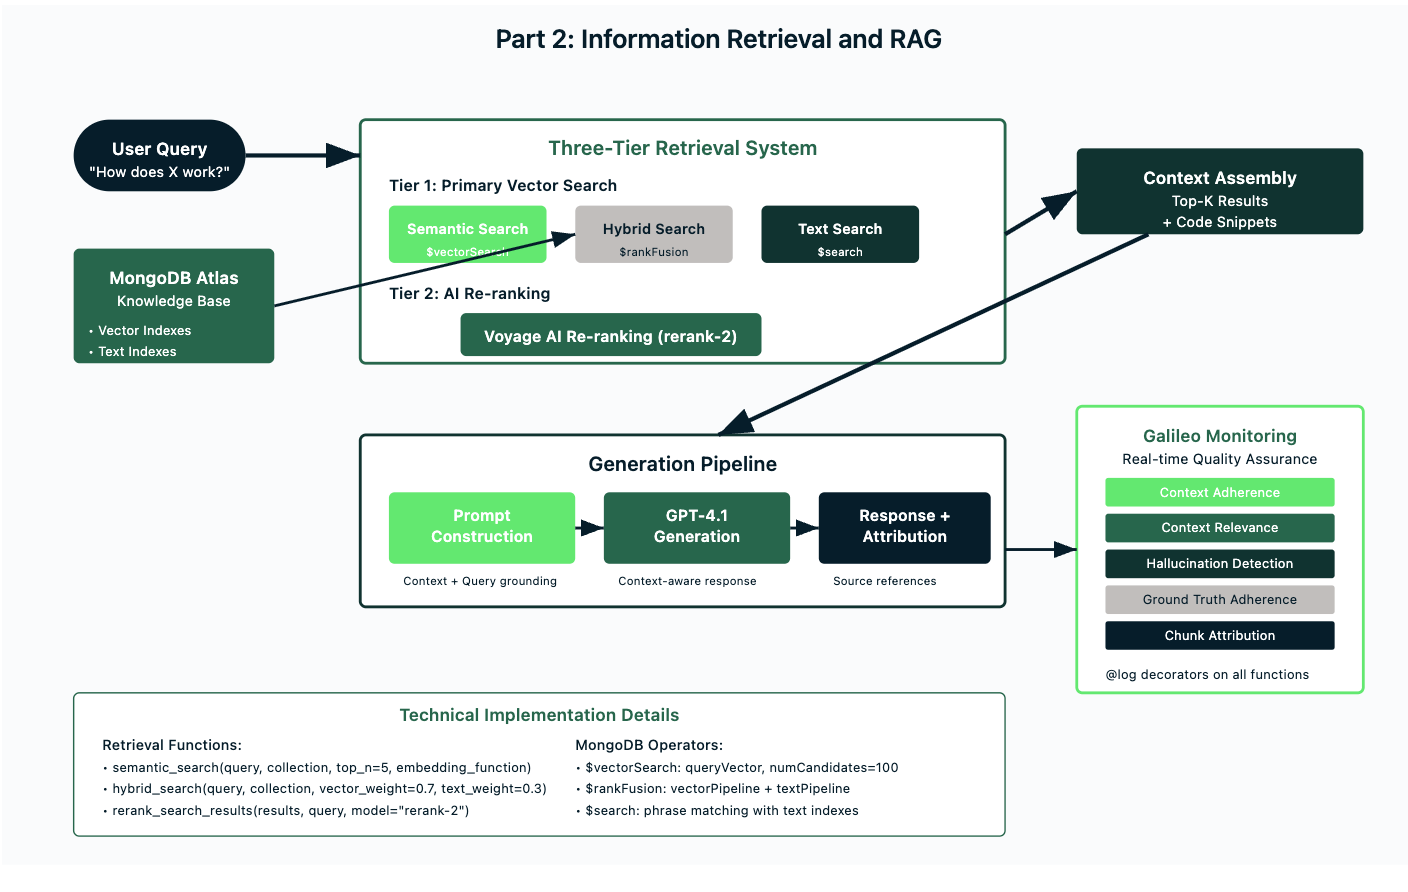

## 2.1 Semantic Search powered by Vector Search

In [16]:
from galileo import log


# Implementing vector search
@log(span_type="retriever", name="semantic_search_vector_search")
def semantic_search(
    user_query,
    collection,
    top_n=5,
    vector_search_index_name="vector_search_index",
    path="embedding",
    embedding_function=get_voyage_embedding,
):
    """
    Perform a vector search in the MongoDB collection based on the user query.

    Args:
    user_query (str): The user's query string.
    collection (MongoCollection): The MongoDB collection to search.
    top_n (int): The number of top results to return.
    vector_search_index_name (str): The name of the vector search index.

    Returns:
    list: A list of matching documents.
    """

    # Retrieve the pre-generated embedding for the query from our dictionary
    # This embedding represents the semantic meaning of the query as a vector
    query_embedding = embedding_function(user_query)

    # Check if we have a valid embedding for the query
    if query_embedding is None:
        return "Invalid query or embedding generation failed."

    # Define the vector search stage using MongoDB's $vectorSearch operator
    # This stage performs the semantic similarity search
    vector_search_stage = {
        "$vectorSearch": {
            "index": vector_search_index_name,  # The vector index we created earlier
            "queryVector": query_embedding,  # The numerical vector representing our query
            "path": path,  # The field containing document embeddings
            "numCandidates": 100,  # Explore this many vectors for potential matches
            "limit": top_n,  # Return only the top N most similar results
        }
    }

    # Define which fields to include in the results and their format
    project_stage = {
        "$project": {
            "_id": 0,  # Exclude MongoDB's internal ID
            "openai_embeddings": 0,
            "voyage_embeddings": 0,
            "score": {
                "$meta": "vectorSearchScore"  # Include similarity score from vector search
            },
        }
    }

    # Combine the search and projection stages into a complete pipeline
    pipeline = [vector_search_stage, project_stage]

    # Execute the pipeline against our collection and get results
    results = collection.aggregate(pipeline)

    # Convert cursor to a Python list for easier handling
    return list(results)

In [66]:
user_query = "Get me the class responsible for creating agents and running them and has all the code for calling LLMs and tools"

In [67]:
search_results_openai_embeddings = semantic_search(
    user_query,
    db[CODEBASE_FILES],
    top_n=10,
    vector_search_index_name="vector_search_index_scalar_openai",
    path="openai_embeddings",
    embedding_function=get_openai_embedding,
)

In [ ]:
import pprint

pprint.pprint(search_results_openai_embeddings)

In [69]:
search_results_voyageai_embeddings = semantic_search(
    user_query,
    db[CODEBASE_FILES],
    top_n=10,
    vector_search_index_name="vector_search_index_scalar_voyage",
    path="voyage_embeddings",
    embedding_function=get_voyage_embedding,
)

In [ ]:
pprint.pprint(search_results_voyageai_embeddings)

In [22]:
# Let's compare the results of the two embeddings

In [71]:
import pandas as pd


def compare_search_results(openai_results, voyage_results):
    """
    Compare two lists of search-result dicts side-by-side.

    Args:
        openai_results (list of dict): Results from OpenAI embeddings search.
        voyage_results (list of dict): Results from Voyage embeddings search.

    Returns:
        pandas.DataFrame: Table with columns for file name, description, and score
                          from each embedding source.
    """
    max_len = max(len(openai_results), len(voyage_results))
    rows = []
    for i in range(max_len):
        oa = openai_results[i] if i < len(openai_results) else {}
        va = voyage_results[i] if i < len(voyage_results) else {}
        rows.append(
            {
                "file_name_openai": oa.get("file_name"),
                "description_openai": oa.get("description"),
                "score_openai": oa.get("score"),
                "file_name_voyage": va.get("file_name"),
                "description_voyage": va.get("description"),
                "score_voyage": va.get("score"),
            }
        )
    return pd.DataFrame(rows)

In [72]:
search_results_comparison_df = compare_search_results(
    search_results_openai_embeddings, search_results_voyageai_embeddings
)

In [73]:
search_results_comparison_df

,file_name_openai,description_openai,score_openai,file_name_voyage,description_voyage,score_voyage
0,memagent.py,```markdown\nmemagent.py defines a memory-driv...,0.709744,memagent.py,```markdown\nmemagent.py defines a memory-driv...,0.835912
1,multi_agent_orchestrator.py,Description: Coordinates and manages asynchron...,0.679546,test_memagent_enhanced_tools.py,Description: This file contains tests for the ...,0.805434
2,memagents_multi_agents.ipynb,A Jupyter notebook that demonstrates the usage...,0.673744,memagents_multi_agents.ipynb,A Jupyter notebook that demonstrates the usage...,0.799671
3,cwm.py,`cwm.py` provides functionality related to mem...,0.669525,cwm.py,`cwm.py` provides functionality related to mem...,0.798085
4,test_memagent_enhanced_tools.py,Description: This file contains tests for the ...,0.669024,multi_agent_orchestrator.py,Description: Coordinates and manages asynchron...,0.793270
5,README.md,A detailed overview and guide for the Memorizz...,0.667534,evaluate_delegate_pattern.py,`evaluate_delegate_pattern.py` is a script for...,0.789808
6,ollama.py,Description: Provides an interface for generat...,0.662606,ollama.py,Description: Provides an interface for generat...,0.773065
7,memagent_single_agent.ipynb,A Jupyter notebook that demonstrates using the...,0.657870,README.md,A detailed overview and guide for the Memorizz...,0.770301
8,evaluate_delegate_pattern.py,`evaluate_delegate_pattern.py` is a script for...,0.656066,memagent_single_agent.ipynb,A Jupyter notebook that demonstrates using the...,0.768837
9,__init__.py,Initializes the package by importing the Memor...,0.649194,README.md,Provides an overview and usage instructions fo...,0.768617


Vector Search is not all you need

## 2.2 Hybrid Search (Semantic + Text)

In [75]:
@log(span_type="retriever", name="hybrid_search")
def hybrid_search(
    user_query,
    collection,
    top_n=5,
    vector_search_index_name="vector_search_index_scalar",
    text_search_index_name="text_search_index",
    vector_weight=0.7,
    text_weight=0.3,
    embedding_function=get_voyage_embedding,
    embedding_path="embedding",
    text_path="text",
):
    """
    Perform hybrid search using both vector and text search with MongoDB RankFusion.

    Args:
        user_query (str): The user's query or search term.
        collection (Collection): MongoDB collection object.
        top_n (int): Number of results to return.
        vector_search_index_name (str): Name of the vector search index.
        text_search_index_name (str): Name of the text search index.
        vector_weight (float): Weight for vector search results (0.0-1.0).
        text_weight (float): Weight for text search results (0.0-1.0).
        embedding_function (function): Function to generate embeddings.
        path (str): Path to the embedding field.

    Returns:
        List[Dict]: List of search results with scores and details.
    """

    # Convert user query to embedding for vector search
    query_embedding = embedding_function(user_query)

    # Build the RankFusion aggregation pipeline
    rank_fusion_stage = {
        "$rankFusion": {
            "input": {
                "pipelines": {
                    "vectorPipeline": [
                        {
                            "$vectorSearch": {
                                "index": vector_search_index_name,
                                "path": embedding_path,
                                "queryVector": query_embedding,
                                "numCandidates": 100,
                                "limit": 20,
                            }
                        }
                    ],
                    "textPipeline": [
                        {
                            "$search": {
                                "index": text_search_index_name,
                                "phrase": {
                                    "query": user_query,
                                    "path": text_path,
                                },
                            }
                        },
                        {"$limit": 20},
                    ],
                }
            },
            "combination": {
                "weights": {
                    "vectorPipeline": vector_weight,
                    "textPipeline": text_weight,
                }
            },
            "scoreDetails": True,
        }
    }

    # Project stage to select desired fields and include score details
    project_stage = {
        "$project": {
            "_id": 0,
            "openai_embeddings": 0,
            "voyage_embeddings": 0,
            "score": {"$meta": "scoreDetails"},
        }
    }

    # Final limit stage
    limit_stage = {"$limit": top_n}

    # Combine all stages into the complete aggregation pipeline
    pipeline = [rank_fusion_stage, project_stage, limit_stage]

    try:
        # Execute the pipeline against the collection
        results = list(collection.aggregate(pipeline))

        print(f"Found {len(results)} results for query: '{user_query}'")

        return results

    except Exception as e:
        print(f"Error executing hybrid search: {e}")
        return []

In [76]:
hybrid_search_results_voyage_embeddings = hybrid_search(
    user_query,
    db[CODEBASE_FILES],
    top_n=5,
    vector_weight=0.5,
    text_weight=0.5,
    vector_search_index_name="vector_search_index_scalar_voyage",
    text_search_index_name="codebase_files_index",
    embedding_path="voyage_embeddings",
    text_path="content",
    embedding_function=get_voyage_embedding,
)

Found 5 results for query: 'Get me the class responsible for creating agents and running them and has all the code for calling LLMs and tools'


In [77]:
hybrid_search_results_openai_embeddings = hybrid_search(
    user_query,
    db[CODEBASE_FILES],
    top_n=5,
    vector_weight=0.5,
    text_weight=0.5,
    vector_search_index_name="vector_search_index_scalar_openai",
    text_search_index_name="codebase_files_index",
    embedding_path="openai_embeddings",
    text_path="content",
    embedding_function=get_openai_embedding,
)

Found 5 results for query: 'Get me the class responsible for creating agents and running them and has all the code for calling LLMs and tools'


In [78]:
search_results_comparison_df = compare_search_results(
    hybrid_search_results_openai_embeddings, hybrid_search_results_voyage_embeddings
)

In [79]:
search_results_comparison_df

,file_name_openai,description_openai,score_openai,file_name_voyage,description_voyage,score_voyage
0,memagent.py,```markdown\nmemagent.py defines a memory-driv...,"{'value': 0.00819672131147541, 'description': ...",memagent.py,```markdown\nmemagent.py defines a memory-driv...,"{'value': 0.00819672131147541, 'description': ..."
1,multi_agent_orchestrator.py,Description: Coordinates and manages asynchron...,"{'value': 0.008064516129032258, 'description':...",test_memagent_enhanced_tools.py,Description: This file contains tests for the ...,"{'value': 0.008064516129032258, 'description':..."
2,memagents_multi_agents.ipynb,A Jupyter notebook that demonstrates the usage...,"{'value': 0.007936507936507936, 'description':...",memagents_multi_agents.ipynb,A Jupyter notebook that demonstrates the usage...,"{'value': 0.007936507936507936, 'description':..."
3,cwm.py,`cwm.py` provides functionality related to mem...,"{'value': 0.0078125, 'description': 'value out...",cwm.py,`cwm.py` provides functionality related to mem...,"{'value': 0.0078125, 'description': 'value out..."
4,test_memagent_enhanced_tools.py,Description: This file contains tests for the ...,"{'value': 0.007692307692307693, 'description':...",multi_agent_orchestrator.py,Description: Coordinates and manages asynchron...,"{'value': 0.007692307692307693, 'description':..."


In [81]:
def generate_answer_from_search(
    user_query: str,
    model: str = "gpt-4.1",
    max_snippet_chars: int = 200,
    embedding_model_provider: str = "voyage",
    num_search_results: int = 5,
) -> str:
    """
    Use code search results as context to answer a user query via the OpenAI Response API.

    Args:
        search_results: List of dicts, each with keys:
            - file_name (str)
            - description (str)
            - content (str)
            - score (float)
        user_prompt: The user's question or instruction.
        model: OpenAI model to call (default "gpt-4.1").
        max_snippet_chars: How many chars of each file's content to include.

    Returns:
        The assistant's answer as a string.
    """

    # Let's get the search reults

    search_results = []

    if embedding_model_provider == "voyage":
        # Feel free to change the search result method to hybrid search
        search_results = semantic_search(
            user_query,
            db[CODEBASE_FILES],
            top_n=num_search_results,
            vector_search_index_name="vector_search_index_scalar_voyage",
            path="voyage_embeddings",
            embedding_function=get_voyage_embedding,
        )
    elif embedding_model_provider == "openai":
        search_results = semantic_search(
            user_query,
            db[CODEBASE_FILES],
            top_n=num_search_results,
            vector_search_index_name="vector_search_index_scalar_openai",
            path="openai_embeddings",
            embedding_function=get_openai_embedding,
        )

    # Build a contextual prompt
    context_entries = []
    for i, res in enumerate(search_results, start=1):
        fname = res.get("file_name", "")
        desc = res.get("description", "").strip()
        snippet = res.get("content", "").strip().replace("```", "`​``")
        snippet = snippet[:max_snippet_chars]
        context_entries.append(f"{i}. **{fname}** — {desc}\n```{snippet}```")

    context_block = "\n\n".join(context_entries)

    prompt = (
        "You are a helpful assistant. Use the following code search results as context "
        "to answer the user query. Be precise and reference filenames when relevant.\n\n"
        f"### Context\n{context_block}\n\n"
        f"### User Query\n{user_query}\n\n"
        "### Answer\n"
    )

    # Call the Response API
    # response = openai_client.responses.create(model=model, input=prompt)

    response = openai_client.chat.completions.create(
        messages=[{"role": "user", "content": prompt}], model=model
    )

    # response.output_text.strip()
    return search_results, response.choices[0].message.content.strip()

In [82]:
user_query = "Get me the file responsibe for the defintion of the MemAgent class"

search_results, answer = generate_answer_from_search(
    user_query, embedding_model_provider="voyage"
)
print(answer)

The file responsible for the definition of the MemAgent class is memagent.py. This file integrates persona management, OpenAI language model support, and a customizable toolbox for executing tasks, as indicated in both the provided context and the import statements referencing memory components and toolboxes.


In [83]:
search_results, answer = generate_answer_from_search(
    user_query, embedding_model_provider="openai"
)
print(answer)

Based on the provided context, the file responsible for the definition of the MemAgent class is likely **memagent.py**. This file is described as defining a memory-driven agent and integrates persona management, OpenAI language model support, and a customizable toolbox for executing tasks, which fits the expected functionality of a MemAgent class.


ReRanking with VoyageAI (rerank-2)

In [36]:
from typing import Any, Dict, List


@log(span_type="retriever", name="rerank_search_results")
def rerank_search_results(
    search_results: List[Dict[str, Any]],
    user_query: str,
    model: str = "rerank-2",
    top_k: int = 5,
) -> List[Dict[str, Any]]:
    """
    Re-rank semantic search results using Voyage AI's rerank API.

    Args:
        search_results: List of dicts with at least a "description" field.
        user_query:     The original user query string.
        model:          The Voyage rerank model to use (e.g. "rerank-2").
        top_k:          If provided, limit to the top_k highest-scoring results.

    Returns:
        A new list of the original result dicts, each augmented with
        "rerank_score", sorted in descending order of that score.
    """

    # Extract the text snippets to rerank
    documents = [res["description"] for res in search_results]

    if top_k is None:
        top_k = len(documents)

    # Call the rerank endpoint
    resp = vo.rerank(user_query, documents, model=model, top_k=top_k)

    # Build a mapping from snippet → score
    score_map = {r.document: r.relevance_score for r in resp.results}

    # Attach scores and sort
    reranked = []
    for orig in search_results:
        desc = orig.get("description")
        score = score_map.get(desc, 0.0)
        entry = orig.copy()
        entry["rerank_score"] = score
        reranked.append(entry)

    # Sort by new rerank_score descending
    reranked.sort(key=lambda x: x["rerank_score"], reverse=True)

    return reranked

In [37]:
reranked_openai_results = rerank_search_results(
    hybrid_search_results_openai_embeddings, user_query, top_k=5
)

In [38]:
for r in reranked_openai_results:
    print(r["file_name"], r["rerank_score"])

memagent.py 0.6953125
test_memagent_enhanced_tools.py 0.5078125
multi_agent_orchestrator.py 0.486328125
cwm.py 0.484375
memagents_multi_agents.ipynb 0.41015625


In [39]:
reranked_voyage_results = rerank_search_results(
    hybrid_search_results_voyage_embeddings, user_query, top_k=5
)

In [40]:
for r in reranked_voyage_results:
    print(r["file_name"], r["rerank_score"])

memagent.py 0.6953125
test_memagent_enhanced_tools.py 0.5078125
multi_agent_orchestrator.py 0.486328125
cwm.py 0.484375
memagents_multi_agents.ipynb 0.41015625


In [ ]:
# This will upload the trace to Galileo
galileo_context.flush()

# Part 3: Coding Agent

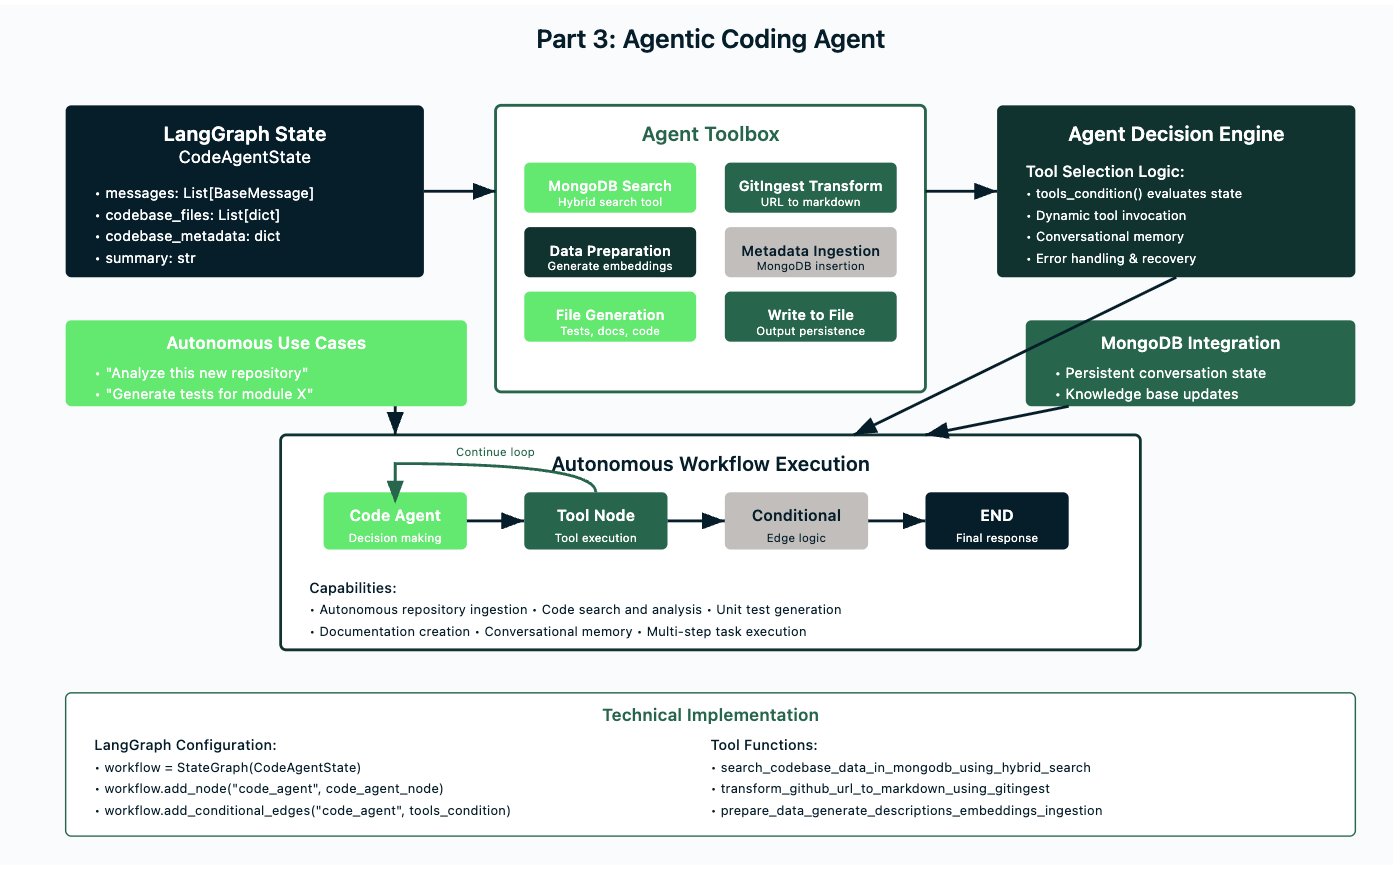

In [41]:
import operator
from typing import Annotated, List, TypedDict

from langchain_core.messages import BaseMessage


class CodeAgentState(TypedDict):
    """State for the code agent."""

    messages: Annotated[List[BaseMessage], operator.add]
    codebase_files: List[dict]
    codebase_metadata: dict
    summary: str
    directory_tree: str
    content: str

Create a tool that can transform github url to markdown content

In [42]:
from langchain.agents import tool


@tool
async def transform_github_url_to_markdown_using_gitingest(github_url: str) -> str:
    """
    Transform a github url into a markdown content.
    """

    summary, tree, content = await ingest_async(github_url)

    return summary, tree, content

Create tool that can prepare metadata for github repo

In [43]:
@tool
def extract_github_metadata_for_ingestion(
    summary: str, directory_tree: str, content: str
) -> str:
    """
    Extract the metadata for ingestion from a github url.
    """

    attrs = {}
    codebase_metadata = {}
    for line in summary.splitlines():
        line = line.strip()
        if not line or ":" not in line:
            continue
        key, val = line.split(":", 1)
        attrs[key.lower().replace(" ", "_")] = val.strip()

    codebase_metadata["repository"] = attrs.get("repository")
    codebase_metadata["analyzed_count"] = attrs.get("files_analyzed")
    codebase_metadata["estimated_tokens"] = attrs.get("estimated_tokens")
    codebase_metadata["tree"] = directory_tree

    # Create the embeddings for the codebase_metadata using OpenAI and VoyageAI
    codebase_metadata["openai_embeddings"] = get_openai_embedding(
        codebase_metadata["description"]
    )
    codebase_metadata["voyage_embeddings"] = get_voyage_embedding(
        codebase_metadata["description"]
    )

    # generate_repo_description is a function created earlier in this notebook
    codebase_metadata["description"] = generate_repo_description(
        codebase_metadata, content
    )

    return codebase_metadata

Create a tool that can process the data for ingestion

In [44]:
@tool
def prepare_data_generate_descriptions_embeddings_ingestion(content):
    """
    Prepare the data for ingestion into the database.
    """

    # From the markdown content, we will split the content into segments that represent files
    files = split_content_to_files(content)

    # Generate the descriptions for the each files
    for file in files:
        file["description"] = generate_file_description(file["content"])

        # Create the embeddings for the each files using OpenAI and VoyageAI
        file["openai_embeddings"] = get_openai_embedding(file["description"])
        file["voyage_embeddings"] = get_voyage_embedding(file["description"])

    return files

Ingest data into MongoDB

In [45]:
@tool
def ingest_codebase_metadata_to_mongodb(codebase_metadata: dict):
    """
    Ingest the codebase metadata into the database.
    """

    # Ensure that the collection exists, if not create it
    if CODEBASE_METADATA not in db.list_collection_names():
        db.create_collection(CODEBASE_METADATA)

    # Insert the codebase metadata documents into the collection
    db[CODEBASE_METADATA].insert_many(codebase_metadata)

    return "Codebase metadata ingested successfully"

In [46]:
@tool
def ingest_codebase_files_metadata_to_mongodb(codebase_files: dict):
    """
    Ingest the codebase files metadata into the database.
    """

    # Ensure that the collection exists, if not create it
    if CODEBASE_FILES not in db.list_collection_names():
        db.create_collection(CODEBASE_FILES)

    # Insert the codebase files documents into the collection
    db[CODEBASE_FILES].insert_many(codebase_files)

    return "Codebase metadata ingested successfully"

In [47]:
@tool
def search_codebase_data_in_mongodb_using_hybrid_search(
    user_query: str, top_n: int = 3
):
    """
    Search the codebase using hybrid search.
    """

    hybrid_search_results = hybrid_search(
        user_query,
        db[CODEBASE_FILES],
        top_n=top_n,
        vector_weight=0.5,
        text_weight=0.5,
        vector_search_index_name="vector_search_index_scalar_voyage",
        text_search_index_name="codebase_files_index",
        embedding_path="voyage_embeddings",
        text_path="content",
        embedding_function=get_voyage_embedding,
    )

    return hybrid_search_results

In [ ]:
from pathlib import Path
from typing import Optional, Union


@tool
def write_to_file(
    content: str,
    filename: str,
    extension: str,
    directory: Optional[Union[str, Path]] = None,
) -> Path:
    """
    Write the given content to a file with the specified extension.

    Args:
        content (str): The text content to write into the file.
        filename (str): The base name of the file (without extension).
        extension (str): File extension, with or without leading dot (e.g., 'txt' or '.md').
        directory (Union[str, Path], optional): Target directory to save the file.
            Defaults to current working directory.

    Returns:
        Path: The full path to the written file.
    """
    # Ensure extension starts with a dot
    ext = extension if extension.startswith(".") else f".{extension}"

    # Determine and create target directory
    target_dir = Path(directory) if directory else Path.cwd()
    target_dir.mkdir(parents=True, exist_ok=True)

    # Construct full file path
    file_path = target_dir / f"{filename}{ext}"

    # Write content to the file
    with file_path.open(mode="w", encoding="utf-8") as file:
        file.write(content)

    return file_path

In [49]:
code_agent_toolbox = [
    search_codebase_data_in_mongodb_using_hybrid_search,
    ingest_codebase_files_metadata_to_mongodb,
    ingest_codebase_metadata_to_mongodb,
    prepare_data_generate_descriptions_embeddings_ingestion,
    extract_github_metadata_for_ingestion,
    transform_github_url_to_markdown_using_gitingest,
    write_to_file,
]

In [55]:
from langchain.chat_models import init_chat_model

llm = init_chat_model("openai:gpt-4.1")

In [56]:
code_agent = llm.bind_tools(code_agent_toolbox)

In [57]:
import re


def sanitize_name(name: str) -> str:
    """Sanitize the name to match OpenAI's pattern requirements."""
    # Remove any spaces, <, |, \, /, and >
    sanitized = re.sub(r"[\s<|\\/>]", "_", name)
    # Ensure the name isn't empty
    return sanitized or "anonymous"

In [58]:
import functools

from langchain_core.messages import AIMessage, ToolMessage


def agent_node(state, agent, name):
    # Extract just the messages from the state to pass to the agent
    messages = state["messages"]

    # Ensure all message names are properly sanitized before sending to the agent
    for msg in messages:
        if hasattr(msg, "name"):
            msg.name = sanitize_name(msg.name or "anonymous")

    result = agent.invoke(messages)

    if isinstance(result, ToolMessage):
        # Sanitize tool message name
        result.name = sanitize_name(result.name)
    else:
        # Use a fixed, compliant name for the AI
        result = AIMessage(
            **result.model_dump(exclude={"type", "name"}), name="assistant"
        )

    return {
        "messages": [result],
        "sender": sanitize_name(name),
    }

In [59]:
from langgraph.prebuilt import ToolNode

code_agent_node = functools.partial(agent_node, agent=code_agent, name="Code Agent")
tool_node = ToolNode(code_agent_toolbox, name="tools")

In [60]:
from langgraph.graph import END, StateGraph
from langgraph.prebuilt import tools_condition

workflow = StateGraph(CodeAgentState)

workflow.add_node("code_agent", code_agent_node)
workflow.add_node("tools", tool_node)

workflow.set_entry_point("code_agent")
workflow.add_conditional_edges(
    "code_agent", tools_condition, {"tools": "tools", END: END}
)

workflow.add_edge("tools", "code_agent")

In [61]:
from langgraph.checkpoint.mongodb import AsyncMongoDBSaver
from pymongo import AsyncMongoClient

async_mongodb_client = AsyncMongoClient(os.getenv("MONGODB_URI"))
mongodb_checkpointer = AsyncMongoDBSaver(async_mongodb_client)

graph = workflow.compile(checkpointer=mongodb_checkpointer)

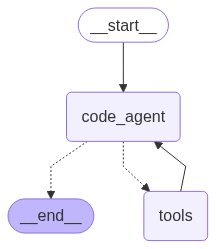

In [62]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [84]:
import asyncio
import time

from langchain_core.messages import AIMessage, HumanMessage


async def chat_loop():
    config = {"configurable": {"thread_id": "200"}}

    while True:
        user_input = await asyncio.get_event_loop().run_in_executor(
            None, input, "User: "
        )
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        # Use a sanitized name for the human
        state = {"messages": [HumanMessage(content=user_input, name="human")]}

        print("Assistant: ", end="", flush=True)

        max_retries = 3
        retry_delay = 1

        for attempt in range(max_retries):
            try:
                async for chunk in graph.astream(state, config, stream_mode="values"):
                    if chunk.get("messages"):
                        last_message = chunk["messages"][-1]
                        if isinstance(last_message, AIMessage):
                            # Ensure the AI name is properly sanitized
                            last_message.name = "assistant"
                            print(last_message.content, end="", flush=True)
                        elif isinstance(last_message, ToolMessage):
                            # Sanitize tool names as well
                            tool_name = sanitize_name(last_message.name)
                            print(f"\n[Tool Used: {tool_name}]")
                            print(f"Tool Call ID: {last_message.tool_call_id}")
                            print(f"Content: {last_message.content}")
                            print("Assistant: ", end="", flush=True)
                break
            except Exception as e:
                if attempt < max_retries - 1:
                    print(f"\nAn unexpected error occurred: {e!s}")
                    print(f"\nRetrying in {retry_delay} seconds...")
                    await asyncio.sleep(retry_delay)
                    retry_delay *= 2
                else:
                    print(f"\nMax retries reached. Error: {e!s}")
                    break

        print("\n")  # New line after the complete response

In [85]:
# For Jupyter notebooks and IPython environments
import nest_asyncio

nest_asyncio.apply()

# Run the async function
await chat_loop()

Assistant: Hello! How can I help you today?

/Users/richmondalake/miniconda3/envs/galileo_webinars/lib/python3.11/site-packages/pydantic/main.py:463: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `CompletionTokensDetails` - serialized value may not be as expected [input_value={'accepted_prediction_tok...d_prediction_tokens': 0}, input_type=dict])
  PydanticSerializationUnexpectedValue(Expected `PromptTokensDetails` - serialized value may not be as expected [input_value={'audio_tokens': 0, 'cached_tokens': 0}, input_type=dict])
  return self.__pydantic_serializer__.to_python(




Assistant: 

/Users/richmondalake/miniconda3/envs/galileo_webinars/lib/python3.11/site-packages/pydantic/main.py:463: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `CompletionTokensDetails` - serialized value may not be as expected [input_value={'accepted_prediction_tok...d_prediction_tokens': 0}, input_type=dict])
  PydanticSerializationUnexpectedValue(Expected `PromptTokensDetails` - serialized value may not be as expected [input_value={'audio_tokens': 0, 'cached_tokens': 0}, input_type=dict])
  return self.__pydantic_serializer__.to_python(
Error occurred during execution: add_retriever_span: A trace needs to be created in order to add a span.


Found 1 results for query: 'toolbox file'

[Tool Used: search_codebase_data_in_mongodb_using_hybrid_search]
Tool Call ID: call_yuXue5hDccvTW3VPMZrdeVLc
Content: [{"file_name": "__init__.py", "content": "from .toolbox import Toolbox\n\n__all__ = ['Toolbox']", "description": "Initializes the package by exposing the Toolbox class from the toolbox module as the primary public interface.", "score": {"value": 0.00819672131147541, "description": "value output by reciprocal rank fusion algorithm, computed as sum of (weight * (1 / (60 + rank))) across input pipelines from which this document is output, from:", "details": [{"inputPipelineName": "textPipeline", "rank": 0, "weight": 0.5}, {"inputPipelineName": "vectorPipeline", "rank": 1, "weight": 0.5, "value": 0.8405945301055908, "details": []}]}}]
Assistant: 

/Users/richmondalake/miniconda3/envs/galileo_webinars/lib/python3.11/site-packages/pydantic/main.py:463: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `CompletionTokensDetails` - serialized value may not be as expected [input_value={'accepted_prediction_tok...d_prediction_tokens': 0}, input_type=dict])
  PydanticSerializationUnexpectedValue(Expected `PromptTokensDetails` - serialized value may not be as expected [input_value={'audio_tokens': 0, 'cached_tokens': 0}, input_type=dict])
  return self.__pydantic_serializer__.to_python(
Error occurred during execution: add_retriever_span: A trace needs to be created in order to add a span.


Found 1 results for query: 'toolbox.py'

[Tool Used: search_codebase_data_in_mongodb_using_hybrid_search]
Tool Call ID: call_qCx6GcnL1y7nOjlu6FltBAbC
Content: [{"file_name": "__init__.py", "content": "from .toolbox import Toolbox\n\n__all__ = ['Toolbox']", "description": "Initializes the package by exposing the Toolbox class from the toolbox module as the primary public interface.", "score": {"value": 0.00819672131147541, "description": "value output by reciprocal rank fusion algorithm, computed as sum of (weight * (1 / (60 + rank))) across input pipelines from which this document is output, from:", "details": [{"inputPipelineName": "textPipeline", "rank": 0, "weight": 0.5}, {"inputPipelineName": "vectorPipeline", "rank": 1, "weight": 0.5, "value": 0.8770365715026855, "details": []}]}}]
Assistant: I found a reference to a Toolbox class being imported in the __init__.py file, which indicates there is a toolbox.py file or module containing the Toolbox class. However, I did not find the a

/Users/richmondalake/miniconda3/envs/galileo_webinars/lib/python3.11/site-packages/pydantic/main.py:463: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `CompletionTokensDetails` - serialized value may not be as expected [input_value={'accepted_prediction_tok...d_prediction_tokens': 0}, input_type=dict])
  PydanticSerializationUnexpectedValue(Expected `PromptTokensDetails` - serialized value may not be as expected [input_value={'audio_tokens': 0, 'cached_tokens': 0}, input_type=dict])
  return self.__pydantic_serializer__.to_python(




Assistant: Absolutely! To write unit tests for toolbox.py, I'll need to see the code for the Toolbox class or the main functions within toolbox.py. This will ensure that the tests are relevant and accurate.

Could you please share the contents of toolbox.py or describe the main methods/classes it contains? If you want me to try and retrieve it automatically, let me know!

/Users/richmondalake/miniconda3/envs/galileo_webinars/lib/python3.11/site-packages/pydantic/main.py:463: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `CompletionTokensDetails` - serialized value may not be as expected [input_value={'accepted_prediction_tok...d_prediction_tokens': 0}, input_type=dict])
  PydanticSerializationUnexpectedValue(Expected `PromptTokensDetails` - serialized value may not be as expected [input_value={'audio_tokens': 0, 'cached_tokens': 0}, input_type=dict])
  return self.__pydantic_serializer__.to_python(




Assistant: 

/Users/richmondalake/miniconda3/envs/galileo_webinars/lib/python3.11/site-packages/pydantic/main.py:463: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `CompletionTokensDetails` - serialized value may not be as expected [input_value={'accepted_prediction_tok...d_prediction_tokens': 0}, input_type=dict])
  PydanticSerializationUnexpectedValue(Expected `PromptTokensDetails` - serialized value may not be as expected [input_value={'audio_tokens': 0, 'cached_tokens': 0}, input_type=dict])
  return self.__pydantic_serializer__.to_python(
Error occurred during execution: add_retriever_span: A trace needs to be created in order to add a span.


Found 2 results for query: 'toolbox.py file content'

[Tool Used: search_codebase_data_in_mongodb_using_hybrid_search]
Tool Call ID: call_L8igXlU7Fa5aY4ASasUyQNEw
Content: [{"file_name": "__init__.py", "content": "from .toolbox import Toolbox\n\n__all__ = ['Toolbox']", "description": "Initializes the package by exposing the Toolbox class from the toolbox module as the primary public interface.", "score": {"value": 0.00819672131147541, "description": "value output by reciprocal rank fusion algorithm, computed as sum of (weight * (1 / (60 + rank))) across input pipelines from which this document is output, from:", "details": [{"inputPipelineName": "textPipeline", "rank": 0, "weight": 0.5}, {"inputPipelineName": "vectorPipeline", "rank": 1, "weight": 0.5, "value": 0.8781752586364746, "details": []}]}}, {"file_name": "toolbox.py", "content": "from typing import Dict, Any, List, Callable, Optional, Union, TYPE_CHECKING\nfrom ..memory_provider import MemoryProvider\nfrom ..memory_provider.me

/Users/richmondalake/miniconda3/envs/galileo_webinars/lib/python3.11/site-packages/pydantic/main.py:463: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `CompletionTokensDetails` - serialized value may not be as expected [input_value={'accepted_prediction_tok...d_prediction_tokens': 0}, input_type=dict])
  PydanticSerializationUnexpectedValue(Expected `PromptTokensDetails` - serialized value may not be as expected [input_value={'audio_tokens': 0, 'cached_tokens': 1024}, input_type=dict])
  return self.__pydantic_serializer__.to_python(




Assistant: 
[Tool Used: write_to_file]
Tool Call ID: call_reEK8MAQHP53gQgdGRsnAini
Content: /Users/richmondalake/Desktop/Projects/open_source/GenAI-Showcase/partners/galileo/test_toolbox.py
Assistant: 

/Users/richmondalake/miniconda3/envs/galileo_webinars/lib/python3.11/site-packages/pydantic/main.py:463: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `CompletionTokensDetails` - serialized value may not be as expected [input_value={'accepted_prediction_tok...d_prediction_tokens': 0}, input_type=dict])
  PydanticSerializationUnexpectedValue(Expected `PromptTokensDetails` - serialized value may not be as expected [input_value={'audio_tokens': 0, 'cached_tokens': 0}, input_type=dict])
  return self.__pydantic_serializer__.to_python(


Unit tests for toolbox.py have been written and saved as test_toolbox.py in your project directory. The tests use unittest and mock the memory provider to cover:

- Tool registration
- Retrieving tools by name and ID
- Similarity search
- Tool deletion by name and ID
- Listing all and available tools
- Getting function by ID
- Updating tool metadata

You can now run these tests with:
```bash
python test_toolbox.py
```
Let me know if you need tests for additional scenarios or a different format!

/Users/richmondalake/miniconda3/envs/galileo_webinars/lib/python3.11/site-packages/pydantic/main.py:463: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `CompletionTokensDetails` - serialized value may not be as expected [input_value={'accepted_prediction_tok...d_prediction_tokens': 0}, input_type=dict])
  PydanticSerializationUnexpectedValue(Expected `PromptTokensDetails` - serialized value may not be as expected [input_value={'audio_tokens': 0, 'cached_tokens': 4096}, input_type=dict])
  return self.__pydantic_serializer__.to_python(




Goodbye!
